In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdrakibulhassan111","key":"a6476eacfc1541b933db4a324abf0c8a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d msambare/fer2013

 78% 47.0M/60.3M [00:00<00:00, 145MB/s]
100% 60.3M/60.3M [00:00<00:00, 152MB/s]


In [ ]:
!ls

fer2013.zip  kaggle.json  sample_data


In [ ]:
from zipfile import ZipFile
file_name = "fer2013.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

In [ ]:
train_dir = 'train'
val_dir = 'test'
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
emotion_model = Sequential()
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

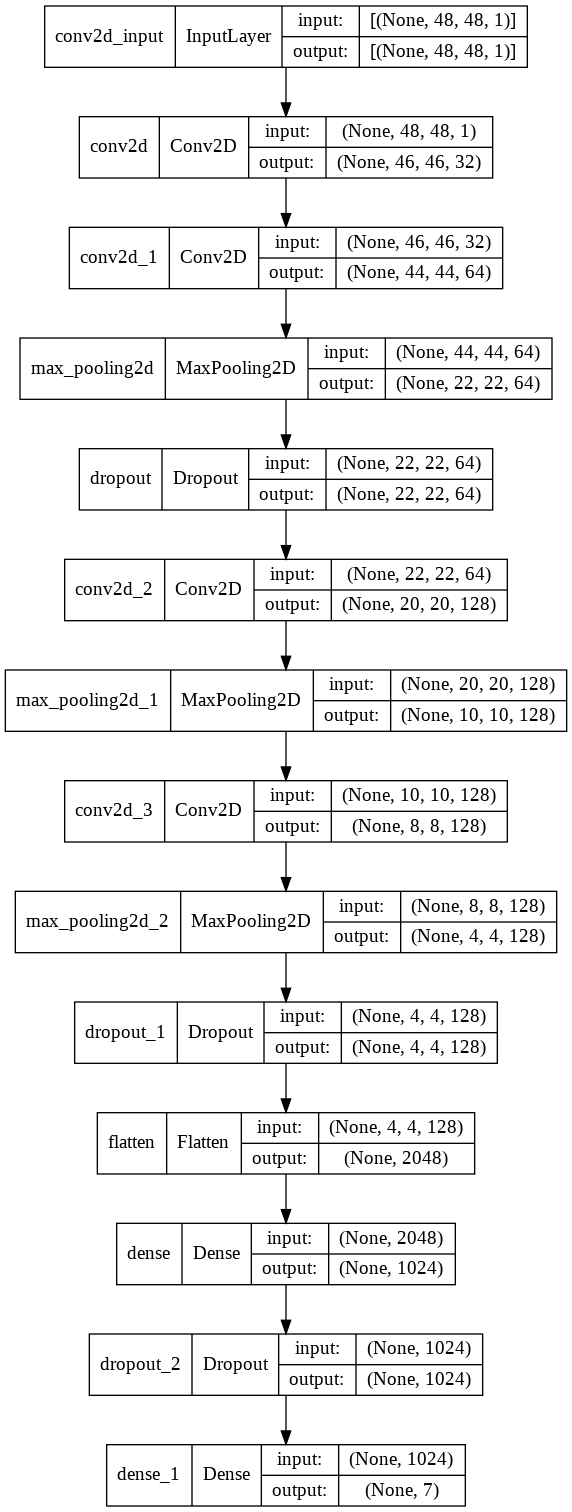

In [ ]:
plot_model(emotion_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
emotion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

In [ ]:
emotion_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
448/448 [==============================] - 29s 42ms/step - loss: 1.7865 - accuracy: 0.2693 - val_loss: 1.6683 - val_accuracy: 0.3486
Epoch 2/50
448/448 [==============================] - 18s 40ms/step - loss: 1.5906 - accuracy: 0.3859 - val_loss: 1.4926 - val_accuracy: 0.4343
Epoch 3/50
448/448 [==============================] - 18s 40ms/step - loss: 1.4834 - accuracy: 0.4310 - val_loss: 1.4103 - val_accuracy: 0.4714
Epoch 4/50
448/448 [==============================] - 18s 40ms/step - loss: 1.4170 - accuracy: 0.4615 - val_loss: 1.3643 - val_accuracy: 0.4900
Epoch 5/50
448/448 [==============================] - 18s 40ms/step - loss: 1.3625 - accuracy: 0.4819 - val_loss: 1.3219 - val_accuracy: 0.5033
Epoch 6/50
448/448 [==============================] - 18s 40ms/step - loss: 1.3170 - accuracy: 0.5014 - val_loss: 1.2892 - val_accuracy: 0.5077
Epoch 7/50
448/448 [==============================] - 21s 46ms/step - loss: 1.2795 - accuracy: 0.5164 - val_loss: 1.2634 - val_accuracy:

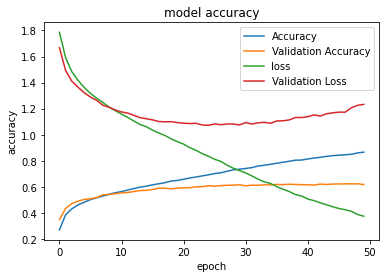

In [ ]:
from matplotlib import pyplot as plt
plt.plot(emotion_model_info.history['accuracy'])
plt.plot(emotion_model_info.history['val_accuracy'])
plt.plot(emotion_model_info.history['loss'])
plt.plot(emotion_model_info.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"],loc='upper left')
plt.show()


In [ ]:
#Saving the model
emotion_model.save('model.h5')

In [ ]:
from keras.models import load_model
emotion_model = load_model('model.h5')

In [ ]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [ ]:


from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

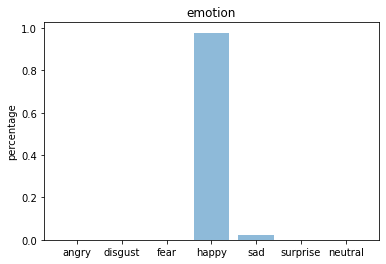

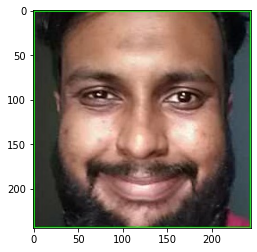

In [ ]:
import cv2
            
def facecrop(image):  
    facedata = '/content/haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            
            cv2.imwrite('photo.jpg', sub_face)
            #print ("Writing: " + image)

    except Exception as e:
        print (e)

   


if __name__ == '__main__':
    facecrop('/content/photo.jpg')

#Testing a file.

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = '/content/photo.jpg'
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = emotion_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);


plt.imshow(true_image)
plt.show()